In this lab, a [Shazam](http://bit.ly/1fvTDIQ)-similar system is implemented. An acoustic fingerprint of a song is generated by hashing the frequency and time information in the spectrogram. A fingerprint of a snippet is later generated and searched through the database of hashes. A high number of matches is found if the snippet comes from the corresponding song. 

# Shazam: Audio Recognition System

As usual, we set the pylab inline option and import necessary modules. 

In [300]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.ndimage.filters import maximum_filter # find the peaks in the spectrogram
from scipy.ndimage.morphology import (generate_binary_structure,iterate_structure)
from pydub import AudioSegment #read wav file.
import hashlib # to generate hash from the frequency and time information

%matplotlib inline

We define a function called readAudioFile to read the **wav** file. *limit* is the number of seconds from the beginning of the song we would like to read. If *limit* is None, readAudioFile returns the data for the whole song. 

In [301]:
def readAudioFile(filename, limit= None):
    audiofile = AudioSegment.from_wav(filename)
  #  print audiofile
    if limit:
        audiofile = audiofile[:limit * 1000]
    data = np.fromstring(audiofile._data, np.int16)
    channels = []
    for chn in xrange(audiofile.channels):
        channels.append(data[chn::audiofile.channels])        
    return channels, audiofile.frame_rate, audiofile

We will implement the Shazam [paper](http://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf). We will refer to figures in this paper. 
Next we define two functions:

1. **get_2D_peaks**: Find the peaks in the spectrogram. Refer to figure 1B of the paper. The set of peaks of the spectrogram is also called the constellation map. 
2. **generate_hashes**: Generate the hashes from the constellation map. See figure 1C and 1D. The struture of the hashes is [f1:f2:delta_t]:t1. Then we call the hashlib function sha1 to generate a single number for our hash. For this demo, I keep the first 25 values of the hash. 

***Question***: does the accuracy of the algorithm increase or decrease if you increase the number of hashes to keep?
It would increase because there is more data per song, but only to an extent.

In [302]:
def get_2D_peaks(arr2D, plot,amp_min = 10):
    struct   = generate_binary_structure(2,1)
    neighborhood  = iterate_structure(struct, 20)
    detected_peaks = maximum_filter(arr2D, footprint  = neighborhood) == arr2D
    amps = arr2D[detected_peaks]
    j,i  = np.where(detected_peaks) 
    amps = amps.flatten()
    peaks = zip(j,i, amps)
    peaks_filtered = [x for x in peaks if x[2]>amp_min]
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]
    if plot: 
        fig, ax = plt.subplots()
        ax.imshow(arr2D)
        ax.scatter(frequency_idx, time_idx)
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        ax.set_title("Spectrogram")
        plt.gca().invert_yaxis()
        plt.axis('tight')
    return zip(frequency_idx, time_idx)
def generate_hashes(peaks, fan_value = 10, len_hash = 25):
    fingerprinted = set()  
    for i in range(len(peaks)):
        for j in range(fan_value):
            if (i + j) < len(peaks) and not (i, i + j) in fingerprinted:
                freq1 = peaks[i][1]
                freq2 = peaks[i + j][1]
                t1 = peaks[i][0]
                t2 = peaks[i + j][0]
                t_delta = t2 - t1
                if t_delta >= 0:
                    h = hashlib.sha1("%s|%s|%s" % (str(freq1), str(freq2), str(t_delta))) 
                    yield (h.hexdigest()[0:len_hash], t1)
                fingerprinted.add((i, i + j))             

The following function **fingerpint** returns the hashes of an audio file. 

In [303]:
def fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot,hash_len = 25):
    arr2D = mlab.specgram(samples, NFFT = wsize, Fs = Fs, window = mlab.window_hanning, noverlap = int(wsize * wratio))[0];
    arr2D = 10 * np.log10(arr2D+0.001)
    arr2D[arr2D == -np.inf] = 0
    local_maxima = get_2D_peaks(arr2D, plot, amp_min = amp_min)
    return generate_hashes(local_maxima, fan_value = fan_value, len_hash = hash_len)

Now we are ready to extract and save the fingerprints. First we read the audio file from the wav folder. You can input your own wav file there. Define sampling rate, window size, overlap ratio between consecutive frames. [pydub](https://github.com/jiaaro/pydub/) can read mp3 file, but you need to configure ffmpeg. You might do that on your own computer.

In [304]:
channels, framerate,data = readAudioFile('data/JonBoden.wav')
Fs = 44100 # sampling freq
wsize  = 4096 # window size
wratio = 0.5 # overlap ratio
fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
amp_min = 25 # minimum amplitude of the peak.
plot = False
for samples in channels:
    hashes = fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot)

For easy visualization and explanation, we will convert our hases into a dictionary of the form: **dict[hash] = t1**. Dictionaries consist of pairs of **keys** and their corresponding **values**. We use the hashes as keys and the time of the hash as value. Since different segments from the audio file can produce the same hash, one key might correspond to multiple values (multiple starting times t1). We use the *defaultdict* data structure to accomodate multiple-valued-single-key entries. 

In [305]:
from collections import defaultdict
def hashesToDict(hashesExcerpt):
    dataExcerpt  = []
    for i in hashesExcerpt:
        dataExcerpt.append(i)
    dictExcerpt = defaultdict(list)
    for hashString, t1 in dataExcerpt:
        dictExcerpt[hashString].append(t1)
    return dictExcerpt

Now we convert the hashes to a dictionary called **dictOriginal**. **dictOriginal** contains all the hashes of the *'JonBoden.wav'* song. The key is the hash and the value is the time. See figure 1D in the paper.

In [306]:
dictOriginal = hashesToDict(hashes)


To implement searching, we could implement [mySQL](http://mysql-python.sourceforge.net/) databases. This provides a systematic approach to store, retrieve and search for hashes. mySQL requires a mySQL server, which adds a level of complexity to this project. For now, we only save the fingperprints into a file and later retrieve them if we need. 

In [307]:
import pickle
fileHandle  = open("JonBoden.fp","wb") #wb: write binary
pickle.dump(dictOriginal, fileHandle)

### Testing the System

Now we load the fingerprinted file back and store it as **dictOriginal**. You can fingerprint as many files as you want, then read all of them here. 

In [308]:
fileHandle = open("JonBoden.fp","rb")
dictOriginal = pickle.load(fileHandle)

**Exercise 1**. Write a function called readAudioFileExcerpt with three inputs. See the readAudioFile function above for guidance. The first input is the filename. The other two inputs are lowLimit and highLimit, which is used to read the audio file from lowLimit to highLimt seconds.

In [309]:
def readAudioFileExcerpt(filename, lowLimit, highLimit):
    audiofile = AudioSegment.from_wav(filename)
    audiofile = audiofile[lowLimit * 1000:highLimit * 1000]
    data = np.fromstring(audiofile._data, np.int16)
    channels = []
    for chn in xrange(audiofile.channels):
        channels.append(data[chn::audiofile.channels]) 
    return channels, audiofile.frame_rate, audiofile

**Excercise 2**. Use your function to read the excerpt from the JonBoden.wav and generate the hashes from this snippet. Name the hahses **hashesExcerpt1**. Also, we've set the plot parameter to True to visualize the peaks of the spectrogram. What parameters in the **fingerprint** function affect the number of peaks?

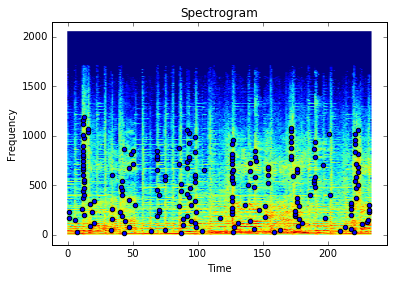

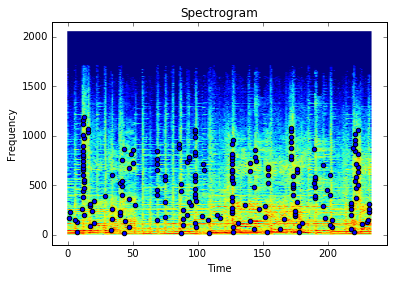

In [310]:
# write your code here.
# read in the audio snippit from 40s to 50s
channelsExcerpt1, framerate, data = readAudioFileExcerpt('data/JonBoden.wav',40,50)
plot = True # but now we want to visualize the peak (pass this as a parameter to get_2D_peaks)

# call the fingerprint function to generate the hashes. 
for samples in channelsExcerpt1:
    hashesExcerpt1 = fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot)


Now we convert the **hashesExcerpt1** to a dictionary. We can call the **hashesToDict** function defined earlier.

In [311]:
dictExcerpt1 = hashesToDict(hashesExcerpt1)

        

**Excercise 3**. Write a function to match the fingerprint of the excerpt to the original song. Return count and delta_k. Count is the number of matching hashes. delta_k is a list of offsets of the database song time and the snippet song time. See section 2.3 of the paper. Read also [this document](http://www.tutorialspoint.com/python/python_dictionary.htm) on how to manipulate the dictionary.

In [312]:
def match_fingerprint(dictExcerpt,dictOriginal):
    count  = 0
    delta_k = []
    for each_hash in dictExcerpt.keys():
        #print each_hash
        #break 
        if each_hash in dictOriginal:
            count += 1
            for each_value in dictExcerpt.get(each_hash):
                delta_k.append(np.subtract(dictOriginal.get(each_hash),each_value))        
    return count, [val for sublist in delta_k for val in sublist]

In [313]:
match_fingerprint(dictExcerpt1, dictOriginal)

(167,
 [-177,
  938,
  2337,
  2518,
  937,
  677,
  1646,
  2949,
  3398,
  99,
  22,
  938,
  160,
  1258,
  2038,
  3565,
  398,
  538,
  1472,
  1553,
  1968,
  3165,
  444,
  562,
  919,
  1265,
  1429,
  1974,
  2302,
  -143,
  -116,
  1120,
  1566,
  2260,
  289,
  2186,
  572,
  1023,
  64,
  173,
  196,
  623,
  813,
  905,
  999,
  1361,
  1604,
  1662,
  2398,
  2445,
  2498,
  2641,
  3073,
  3097,
  3250,
  3367,
  3465,
  3591,
  2735,
  3242,
  -130,
  3049,
  592,
  1474,
  1607,
  1974,
  2954,
  3328,
  938,
  -56,
  304,
  363,
  454,
  609,
  828,
  937,
  973,
  1645,
  1743,
  2009,
  2711,
  2740,
  2879,
  2960,
  3017,
  3293,
  -91,
  269,
  328,
  419,
  574,
  793,
  902,
  938,
  1610,
  1708,
  1974,
  2676,
  2705,
  2844,
  2925,
  2982,
  3258,
  -113,
  247,
  306,
  397,
  552,
  771,
  880,
  916,
  1588,
  1686,
  1952,
  2654,
  2683,
  2822,
  2903,
  2960,
  3236,
  82,
  523,
  742,
  938,
  1537,
  419,
  -103,
  938,
  1817,
  29,
  91,
  153,

Let's count how many matches are found and plot the histogram of the offsets.

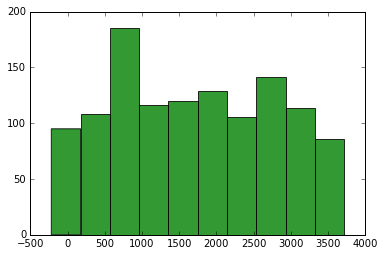

In [314]:
#dictExcerpt1 = hashesToDict(hashesExcerpt1)
count1, delta_k1 = match_fingerprint(dictExcerpt1, dictOriginal)
if delta_k1:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    numBins = 10
    ax.hist(delta_k1,numBins,color='green',alpha=0.8)

**Exercise 4**. Now load the second file, count the number of matches, and plot the histogram of the offsets.

In [325]:
print len(delta_k1)
decs = [int(x/10) for x in delta_k1]
print decs

1200
[-18, 93, 233, 251, 93, 67, 164, 294, 339, 9, 2, 93, 16, 125, 203, 356, 39, 53, 147, 155, 196, 316, 44, 56, 91, 126, 142, 197, 230, -15, -12, 112, 156, 226, 28, 218, 57, 102, 6, 17, 19, 62, 81, 90, 99, 136, 160, 166, 239, 244, 249, 264, 307, 309, 325, 336, 346, 359, 273, 324, -13, 304, 59, 147, 160, 197, 295, 332, 93, -6, 30, 36, 45, 60, 82, 93, 97, 164, 174, 200, 271, 274, 287, 296, 301, 329, -10, 26, 32, 41, 57, 79, 90, 93, 161, 170, 197, 267, 270, 284, 292, 298, 325, -12, 24, 30, 39, 55, 77, 88, 91, 158, 168, 195, 265, 268, 282, 290, 296, 323, 8, 52, 74, 93, 153, 41, -11, 93, 181, 2, 9, 15, 32, 43, 58, 78, 126, 146, 224, 268, 282, 327, 343, 365, -3, 93, 99, 201, -6, 90, 95, 197, -9, 88, 93, 195, 218, 149, 185, 93, 138, 282, 93, 33, 54, 57, 76, 93, 103, 161, 205, 50, 148, 153, 252, 256, 259, 349, 356, 197, 201, 229, 257, -2, 7, 13, 19, 25, 56, 59, 93, 107, 121, 125, 128, 136, 146, 160, 170, 193, 197, 207, 228, 240, 250, 266, 289, 292, 328, 346, 355, 359, -13, -3, 2, 9, 14, 46, 4

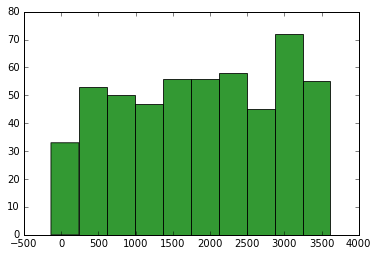

In [315]:
channelsExcerpt2, framerate, data = readAudioFileExcerpt('data/BreakingtheHabit.wav',40,50)

#write code to generate hashesExcerpt2
for samples in channelsExcerpt2:
    hashesExcerpt2 = fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot = False)
dictExcerpt2 = hashesToDict(hashesExcerpt2)
count2, delta_k2 = match_fingerprint(dictExcerpt2, dictOriginal)
if delta_k2:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    numBins = 10
    ax.hist(delta_k2,numBins,color='green',alpha=0.8)

**Exercise 5**. Based on the number of matches (consider how many possible matches there are) and histogram of offsets, justify that your code produces a desirable result. 

The code produces a correct result because the number of matches is much higher in the first graph and than the second graph, as can be seen from the histograph

**Exercise 6.** Now to test the system. Create your own dataset (of at least 100 songs) to test the accuracy of the Shazam system. You will need to generate a dictionary for each song. Use 10% of the songs in the dataset to test for recognition accuracy. Change the length of the hash (len_hash) (try several different values from 10 to 25) and amplitude threshold (amp_min) (try several different values from 5 to 10) and compare the accuracy, speed, and size of the dictionary. What do you think is the optimal trade-off?

**Extra Credit.** There is one component not yet implemented, which is reading the audio snippet from the microphone. This is not mandatory, but you can try it yourself if you have time. It is suggested to use [pyaudio](http://people.csail.mit.edu/hubert/pyaudio/). 

In [238]:
def readAudioFileMp3(filename, limit= None):
    audiofile = AudioSegment.from_mp3(filename)
    if limit:
        audiofile = audiofile[:limit * 1000]
    data = np.fromstring(audiofile._data, np.int16)
    channels = []
    for chn in xrange(audiofile.channels):
        channels.append(data[chn::audiofile.channels])        
    return channels, audiofile.frame_rate, audiofile
def readAudioFileExcerptMp3(filename, lowLimit, highLimit):
    audiofile = AudioSegment.from_mp3(filename)
    audiofile = audiofile[lowLimit * 1000:highLimit * 1000]
    data = np.fromstring(audiofile._data, np.int16)
    channels = []
    for chn in xrange(audiofile.channels):
        channels.append(data[chn::audiofile.channels]) 
    return channels, audiofile.frame_rate, audiofile

### We will read in a test file and compare against an excerpt from itself and then an excerpt from another song

In [239]:
# read test_file
files = os.listdir('test_data')
test_file = files[0]
name = 'test_data/' + test_file
print name
hashListAMP =[[] for i in range(11-5)]
channels, framerate,data = readAudioFileMp3(name)
Fs = 44100 # sampling freq
wsize  = 4096 # window size
wratio = 0.5 # overlap ratio
fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
#amp_min = 25 # minimum amplitude of the peak.
plot = False
i = 0
x = 0
for samples in channels:
    if x == 0:
        x += 1
        continue
    for amp_min in xrange(5,11):
        hashListAMP[i].append(fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot))
        i += 1
        

test_data/Battlefield.mp3


In [240]:
dictOriginals = [[] for i in range(11-5)]
for i in xrange(0,11-5):
    for hashes in hashListAMP[i]:
        dictOriginals[i].append(hashesToDict(hashes))

## An excerpt from itself:

In [241]:
# write your code here.
# read in the audio snippit from 40s to 50s
name = 'test_data/' + files[0]
print name
channelsExcerpt1, framerate, data = readAudioFileExcerptMp3(name,40,50)
hashListAmpExcerpt1 = [[] for i in range(11-5)]
# call the fingerprint function to generate the hashes. 
i = 0
x = 0
for samples in channelsExcerpt1:
    if x == 0:
        x += 1
        continue
    for amp_min in xrange(5,11):
        hashListAmpExcerpt1[i].append(fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot))
        i += 1


test_data/Battlefield.mp3


In [242]:
dictExcerpts1 = [[] for i in range(11-5)]
for i in xrange(0,11-5):
    for hashes in hashListAmpExcerpt1[i]:
        dictExcerpts1[i].append(hashesToDict(hashes))

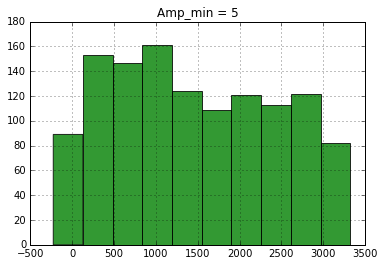

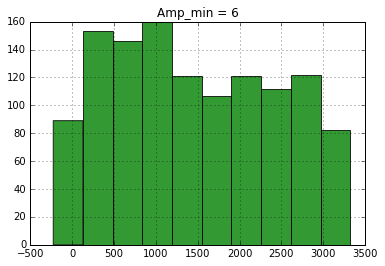

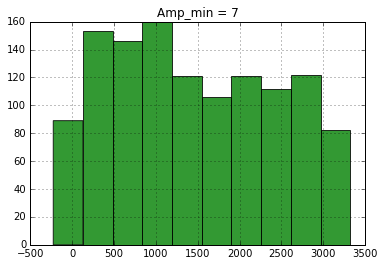

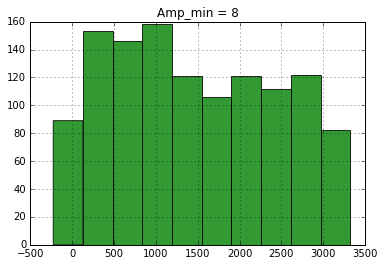

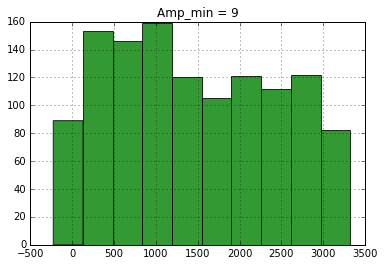

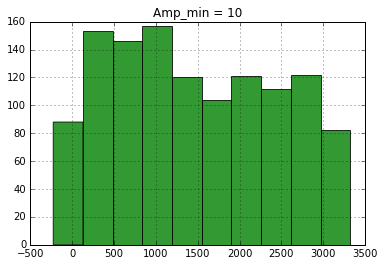

In [244]:
for i in xrange (0,6):
    count2, delta_k2 = match_fingerprint(dictExcerpts1[i][0], dictOriginals[i][0])
    if delta_k2:
        fig = plt.figure()
        plt.title("Amp_min = " + str(i + 5))
        ax = fig.add_subplot(111)
      #  ax.set_xlim([-4000, 4000])
    #    ax.set_ylim([0, 20000])
    #    plt.yticks(np.arange(0, 20000, 1000))
        plt.grid()
        numBins = 10
        ax.hist(delta_k2,numBins,color='green',alpha=0.8)

## An excerpt from a different song

test_data/Be With You.mp3


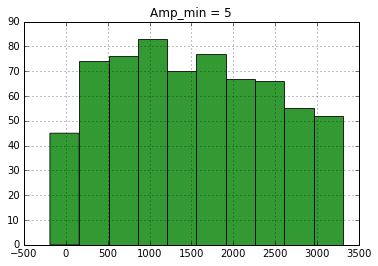

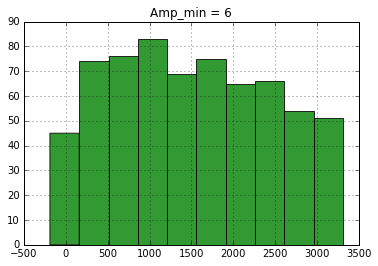

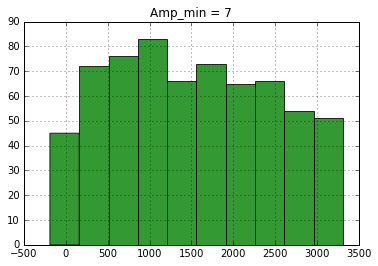

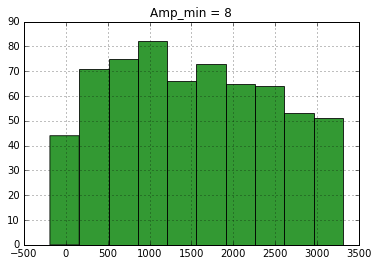

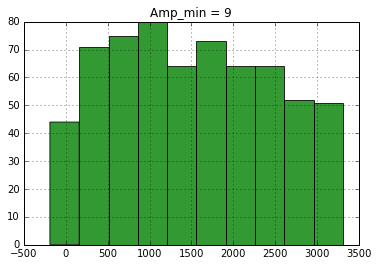

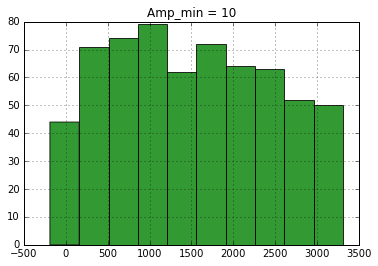

In [245]:
# write your code here.
# read in the audio snippit from 30s to 40s
name = 'test_data/' + files[1]
print name
channelsExcerpt2, framerate, data = readAudioFileExcerptMp3(name,30,40)
hashListAmpExcerpt2 = [[] for i in range(11-5)]
# call the fingerprint function to generate the hashes. 
i = 0
x = 0
plot = False
for samples in channelsExcerpt2:
    if x == 0:
        x += 1
        continue
    for amp_min in xrange(5,11):
        hashListAmpExcerpt2[i].append(fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot))
        i += 1
dictExcerpts2 = [[] for i in range(11-5)]
for i in xrange(0,11-5):
    for hashes in hashListAmpExcerpt2[i]:
        dictExcerpts2[i].append(hashesToDict(hashes))
for i in xrange (0,6):
    count2, delta_k2 = match_fingerprint(dictExcerpts2[i][0], dictOriginals[i][0])
    if delta_k2:
        fig = plt.figure()
        plt.title("Amp_min = " + str(i + 5))
        ax = fig.add_subplot(111)
        plt.grid()
        numBins = 10
        ax.hist(delta_k2,numBins,color='green',alpha=0.8)


### Amp_Min 5 is clearly the best as the peak with the highest matches is above 160, but the actual Amp_min doesn't really matter match even if we take false positives into account. We will use Amp min 5 to test for best len_hash###

## Now testing len_hash. We will again load in the original file with each of the hash between 10 to 26

In [247]:
# read test_file
files = os.listdir('test_data')
test_file = files[0]
name = 'test_data/' + test_file
print name
hashListLength =[[] for i in range(26-10)]
channels, framerate,data = readAudioFileMp3(name)
Fs = 44100 # sampling freq
wsize  = 4096 # window size
wratio = 0.5 # overlap ratio
fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
amp_min = 5 # minimum amplitude of the peak.
plot = False
i = 0
x = 0
for samples in channels:
    if x == 0:
        x += 1
        continue
    for length_h in xrange(10,26):
        hashListLength[i].append(fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot, hash_len = length_h))
        i += 1
        

test_data/Battlefield.mp3


In [ ]:
dictOriginalsHash = [[] for i in range(26-10)]
for i in xrange(0,26-10):
    for hashes in hashListLength[i]:
        dictOriginalsHash[i].append(hashesToDict(hashes))

## Excerpt from same song:

In [256]:
# write your code here.
# read in the audio snippit from 40s to 50s
name = 'test_data/' + files[0]
print name
channelsExcerpt1LEN, framerate, data = readAudioFileExcerptMp3(name,40,50)
hashListLengthExcerpt1 = [[] for i in range(26-10)]
# call the fingerprint function to generate the hashes. 
i = 0
x = 0
for samples in channelsExcerpt1LEN:
    if x == 0:
        x += 1
        continue
    for length_h in xrange(10,26):
        hashListLengthExcerpt1[i].append(fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot, hash_len = length_h))
        i += 1


test_data/Battlefield.mp3


In [257]:
dictExcerptsLength1 = [[] for i in range(26-10)]
for i in xrange(0,26-10):
    for hashes in hashListLengthExcerpt1[i]:
        dictExcerptsLength1[i].append(hashesToDict(hashes))

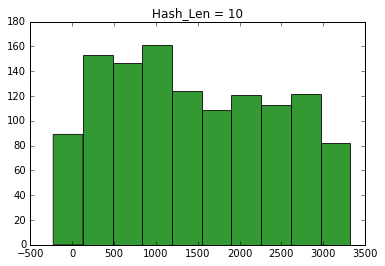

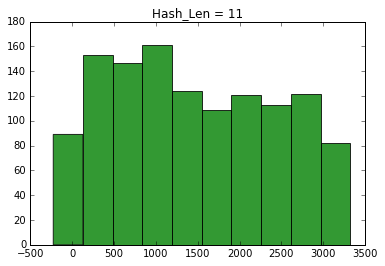

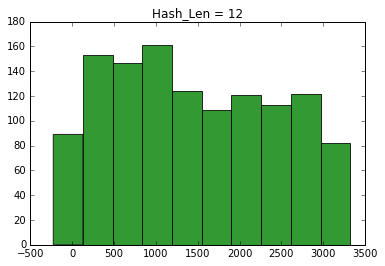

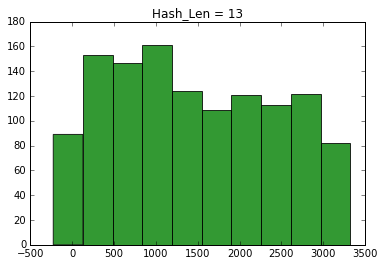

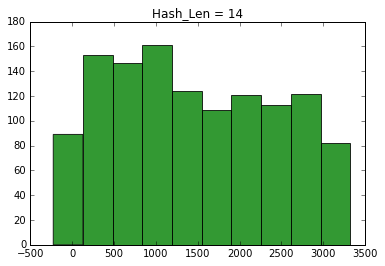

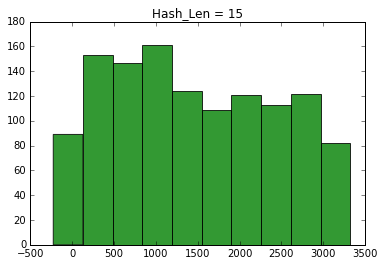

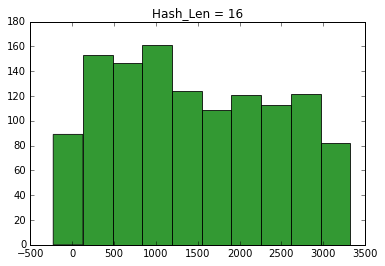

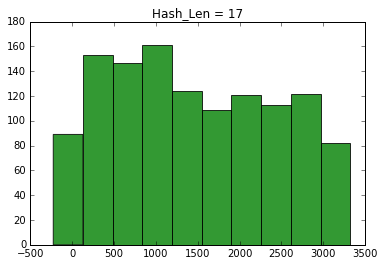

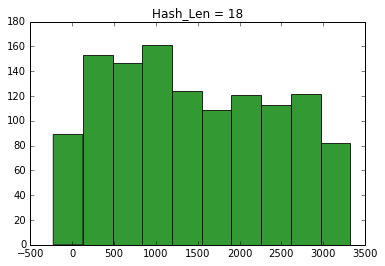

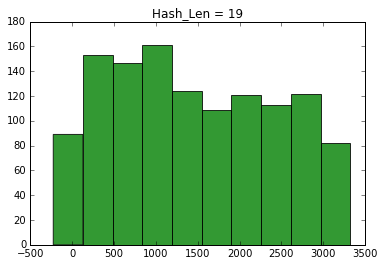

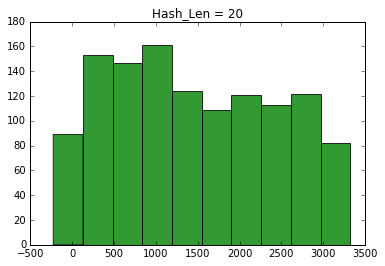

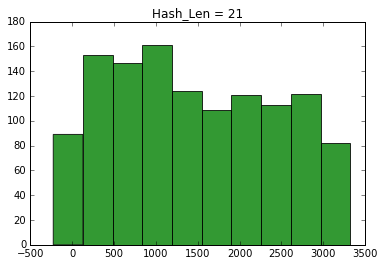

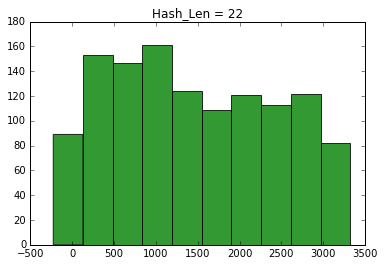

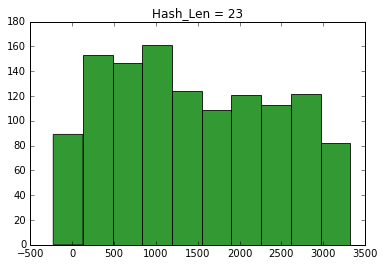

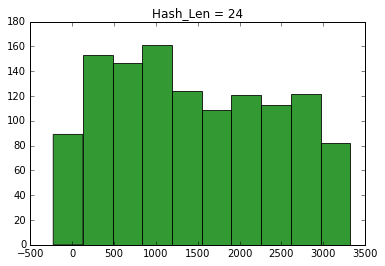

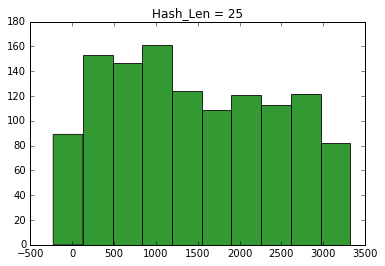

In [258]:
for i in xrange (0,26-10):
    count2, delta_k2 = match_fingerprint(dictExcerptsLength1[i][0], dictOriginalsHash[i][0])
    if delta_k2:
        fig = plt.figure()
        plt.title("Hash_Len = " + str(i + 10))
        ax = fig.add_subplot(111)
        numBins = 10
        ax.hist(delta_k2,numBins,color='green',alpha=0.8)

## Excerpt from different song:

test_data/Be With You.mp3


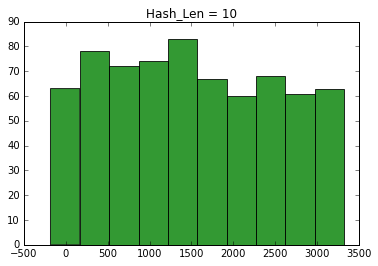

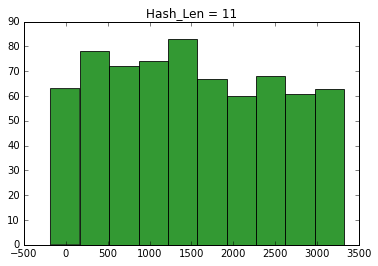

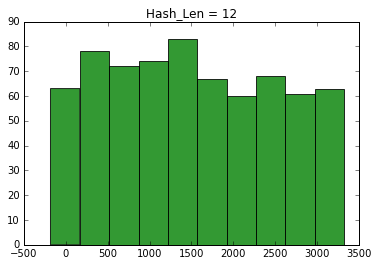

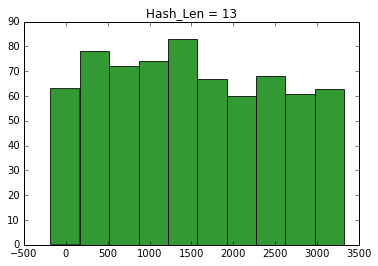

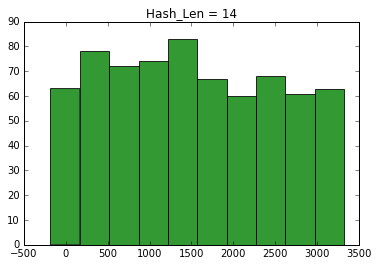

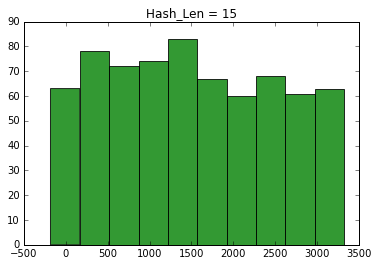

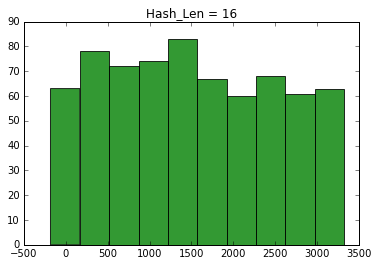

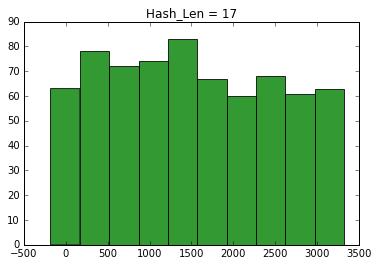

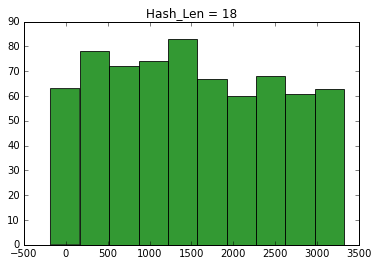

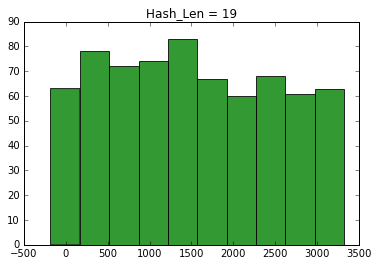

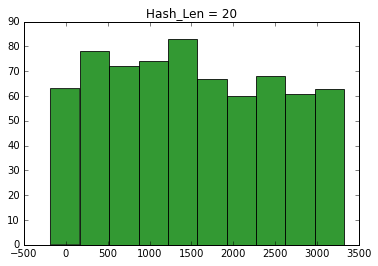

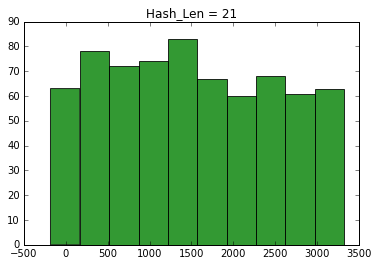

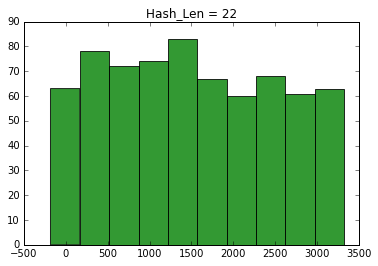

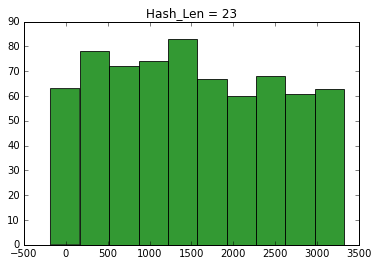

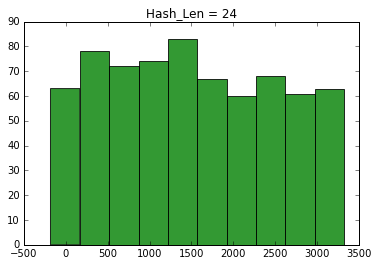

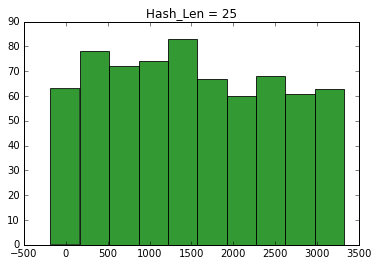

In [261]:
# write your code here.
# read in the audio snippit from 40s to 50s
name = 'test_data/' + files[1]
print name
channelsExcerpt2LEN, framerate, data = readAudioFileExcerptMp3(name,40,50)
hashListLengthExcerpt2 = [[] for i in range(26-10)]
# call the fingerprint function to generate the hashes. 
i = 0
x = 0
for samples in channelsExcerpt2LEN:
    if x == 0:
        x += 1
        continue
    for length_h in xrange(10,26):
        hashListLengthExcerpt2[i].append(fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot, hash_len = length_h))
        i += 1
dictExcerptsLength2 = [[] for i in range(26-10)]
for i in xrange(0,26-10):
    for hashes in hashListLengthExcerpt2[i]:
        dictExcerptsLength2[i].append(hashesToDict(hashes))
for i in xrange (0,26-10):
    count2, delta_k2 = match_fingerprint(dictExcerptsLength2[i][0], dictOriginalsHash[i][0])
    if delta_k2:
        fig = plt.figure()
        plt.title("Hash_Len = " + str(i + 10))
        ax = fig.add_subplot(111)
        numBins = 10
        ax.hist(delta_k2,numBins,color='green',alpha=0.8)

### Length of Hash doesn't seem to make too much difference either. As such, a lower length of hash is better as it reduces the size of the dictionary. Amp_Min and Len_hash don't visibly affect the speed either, although I'd hypothesize that a lower hash length and a higher peak would increase the speed

### Creating a library of 50 dictionaries with amp_min = 5 and Len_hash = 10

In [263]:
import os
files = []
for filename in os.listdir('test_data'):
    name = 'test_data/' + filename
    print name
    channels, framerate,data = readAudioFileMp3(name)
    Fs = 44100 # sampling freq
    wsize  = 4096 # window size
    wratio = 0.5 # overlap ratio
    fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
    amp_min = 5 # minimum amplitude of the peak.
    plot = False
    for samples in channels:
        hashes = fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot, hash_len = 10)
    dictCur = hashesToDict(hashes)
    fileHandle  = open(filename +".fp","wb") #wb: write binary
    pickle.dump(dictCur, fileHandle)
    files.append(filename)
    

test_data/Battlefield.mp3
test_data/Be With You.mp3
test_data/champion.mp3
test_data/22. Before The End.mp3
test_data/03 City of Safe Harbors.mp3
test_data/Best I Ever Had-Drake.mp3
test_data/13 At Anchor.mp3
test_data/04001798.mp3
test_data/02 Butterflies.mp3
test_data/11 Arrival At Sydney Harbour.mp3
test_data/Climax ft. Diplo.mp3
test_data/Early birdie.mp3
test_data/Church.mp3
test_data/18. Danny's Blues.mp3
test_data/01.mp3
test_data/2b75f2a7d9f3ccc9c96b64ec688f86a1.mp3
test_data/06 Elephant Island.mp3
test_data/Clocks-Coldplay.mp3
test_data/Back To New (3LAU Remix).mp3
test_data/best in me.mp3
test_data/24TheSaturdaysEgo.mp3
test_data/preview.mp3
test_data/13. Child.mp3
test_data/Baby Its Cold Outside.mp3
test_data/10 An Enchanted Evening.mp3
test_data/Can't Help But Wait (Album Version).mp3
test_data/owl.mp3
test_data/Cobra-decentlydope.mp3
test_data/breakdown.mp3
test_data/2.mp3
test_data/Earthquake.mp3
test_data/453508.mp3
test_data/boston.mp3
test_data/AZIATIX-Cold.mp3
test_da

In [404]:
def get_excerpt_dict(filename,low,high):
    all_files = os.listdir('test_data')
    name = 'test_data/' + all_files[files.index(filename)]
#    print name
    channels, framerate, data = readAudioFileExcerptMp3(name,low,high)
    Fs = 44100 # sampling freq
    wsize  = 4096 # window size
    wratio = 0.5 # overlap ratio
    fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
    amp_min = 5 # minimum amplitude of the peak.
    plot = False
    for samples in channels:
        hashes = fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot, hash_len = 10)
    return hashesToDict(hashes)
def identify(excerptDict,OGDicts,filenames):
    cur_max = 0
    i = 0
    for each_dict in OGDicts:
        count, delta_k = match_fingerprint(excerptDict, each_dict)
        if delta_k:
            #print count,delta_k
            n, b = np.histogram(delta_k,numBins)
#            print max(n)
            if cur_max < np.amax(n):
                cur_max = np.amax(n)
                right_file = i
        i += 1
    return filenames[right_file]


In [364]:
num_songs = len(files)
OriginalDicts = []
for x in xrange(0,num_songs):
    fileHandle = open(str(files[x]) +".fp","rb")
    OriginalDicts.append(pickle.load(fileHandle))

        

In [406]:
low = 30
high = 40
test_set = np.random.random_integers(0,num_songs-1,int(num_songs *(10.0/100)))
times_correct = 0
for each_song in test_set:
    song_dict = get_excerpt_dict(files[each_song],low,high)
    ID = identify(song_dict,OriginalDicts,files)
    if ID == files[each_song]:
      times_correct+= 1
print str((float(times_correct)/len(test_set)*100)) + "% is our accuracy"

100.0% is our accuracy
